# Sampling

In [1]:
using AutomotiveDrivingModels
using Distributions
using AutoScenes
using AutoViz
using NGSIM

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.4/AutoScenes.ji for module AutoScenes.
ErrorException("The dynamically loaded GMP library (version 6.1.0 with __gmp_bits_per_limb == 64)
does not correspond to the compile time version (version 5.1.3 with __gmp_bits_per_limb == 64).
Please rebuild Julia.")


In [2]:
trajdata = load_trajdata(1);

In [3]:
const REGIONS = Dict{ASCIIString, SubSceneExtractParams}(
  "101A" => SubSceneExtractParams(VecSE2(1966406.608, 570903.793, 2.382), 100.0, 27.0),  
  "101B" => SubSceneExtractParams(VecSE2(1966501.608, 570804.793, 2.425), 100.0, 25.0),
  "101C" => SubSceneExtractParams(VecSE2(1966406.608, 570903.793, 2.382), 100.0, 25.0),
  "80A"  => SubSceneExtractParams(VecSE2(6042777.824, 2133302.509, 1.684)),
  "80B"  => SubSceneExtractParams(VecSE2(6042697.824, 2134372.509, 1.745)),
  )

Dict{ASCIIString,AutoScenes.SubSceneExtractParams} with 5 entries:
  "80A"  => AutoScenes.SubSceneExtractParams(VecSE2({6042777.824, 2133302.509},…
  "101B" => AutoScenes.SubSceneExtractParams(VecSE2({1966501.608, 570804.793}, …
  "101A" => AutoScenes.SubSceneExtractParams(VecSE2({1966406.608, 570903.793}, …
  "80B"  => AutoScenes.SubSceneExtractParams(VecSE2({6042697.824, 2134372.509},…
  "101C" => AutoScenes.SubSceneExtractParams(VecSE2({1966406.608, 570903.793}, …

In [4]:
dset = pull_scene_dataset(trajdata, REGIONS["101B"])
length(dset)

736

In [5]:
sg = SceneGenerator(dset.factors, MvNormal([1.0,0.5,0.5,0.1]), 2)

SceneGenerator(burnin=2)

VecE2(1966488.793, 570820.198)


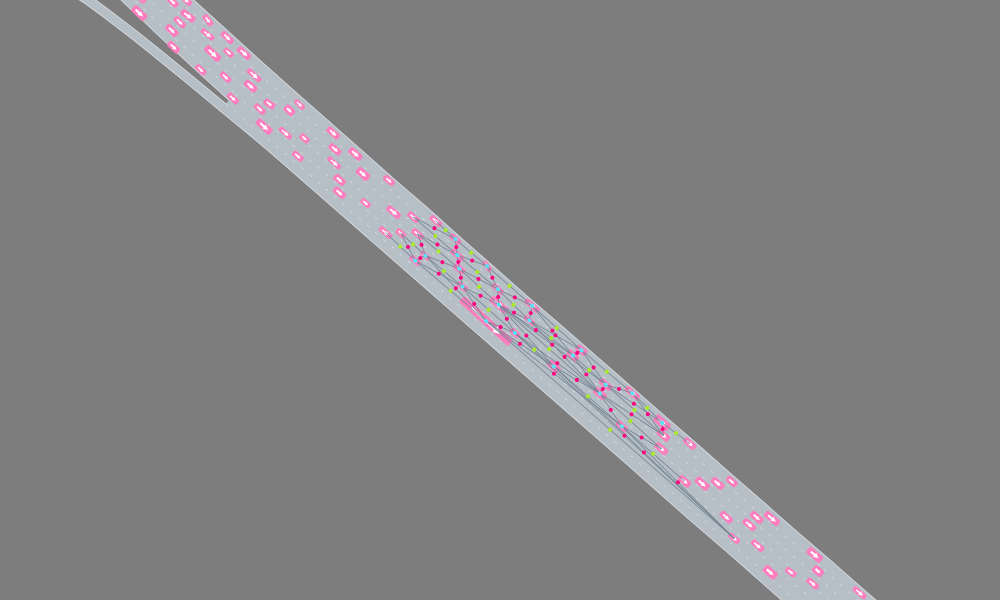

In [6]:
scene, source, structure, roadway = sample(sg, dset)

overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
render(scene, roadway, overlays, cam=SceneFollowCamera(3.0))

Interact.Slider{Int64}(Signal{Int64}(500, nactions=0),"i",500,1:1000,"d",true)

VecE2(1966497.081, 570813.068)
VecE2(1966497.081, 570813.068)


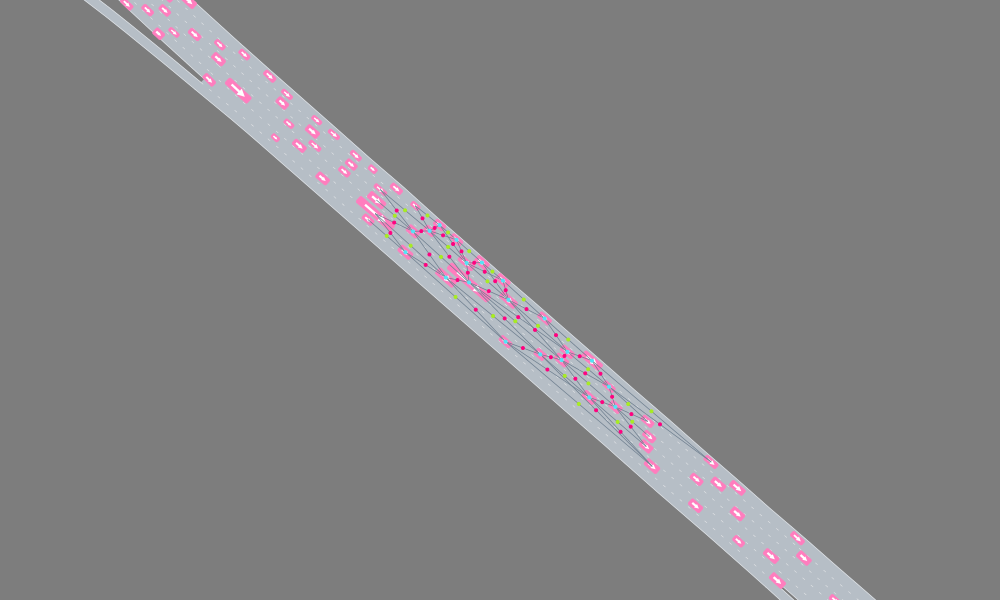

In [7]:
using Interact

starting_scene_index = rand(1:length(dset))
source = dset.sources[starting_scene_index]
scene, structure, roadway = get_scene_structure_and_roadway!(Scene(), dset, starting_scene_index)
overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]

@manipulate for i in 1 : 1000

    overlays = SceneOverlay[Overwash(RGBA(1.0,1.0,1.0,0.7)), SceneStructureOverlay(structure)]
    render(scene, roadway, overlays, cam=SceneFollowCamera(3.0))
    
    metropolis_hastings_step!(scene, structure, roadway, sg.factors,
                         sg.propsal_distribution, sg.Δ_propose, sg.mem, sg.rec)
    
    render(scene, roadway, overlays, cam=SceneFollowCamera(3.0))
end